In [1]:
from matplotlib import pyplot as plt


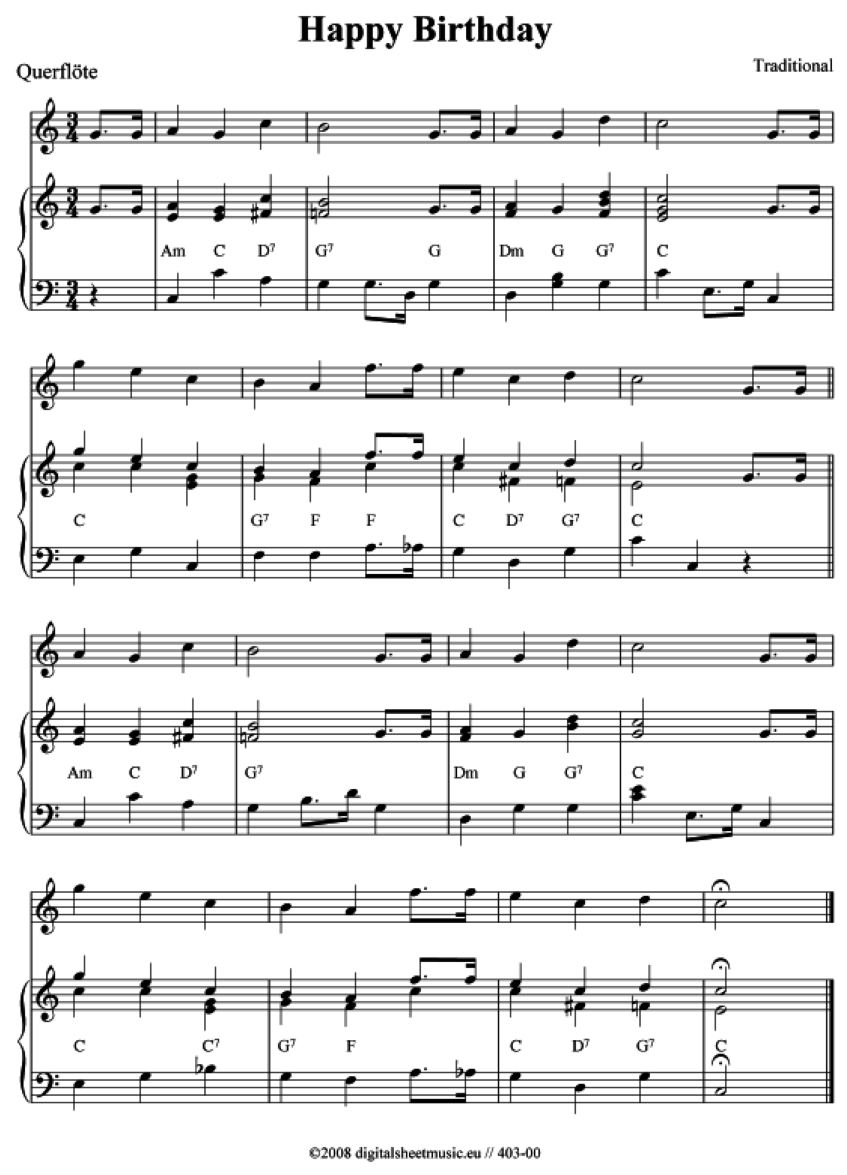

In [3]:
imagepath = 'image.png' 

img = plt.imread(imagepath)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.imshow(img)
plt.show()

In [5]:
import subprocess
import os

def run_homr_cli(image_path):
    # Umgebungsvariablen für diesen Prozess kopieren und erweitern
    env = os.environ.copy()
    env["QT_QPA_PLATFORM"] = "offscreen"
    
    command = ["homr", image_path]
    # Oder ["python3", "-m", "homr.main", image_path]
    
    try:
        result = subprocess.run(
            command,
            env=env,
            check=True,
            capture_output=True,
            text=True
        )
        print("Erfolg:", result.stdout)
    except subprocess.CalledProcessError as e:
        print("Fehler beim Ausführen von HOMR:")
        print(e.stderr)

In [6]:
run_homr_cli(imagepath)

Erfolg: 


In [7]:
# PFAD ANPASSEN
ms_path = 'musescore3'
ms_path = r"C:\Program Files\MuseScore 4\bin\MuseScore4.exe"

In [8]:
xml_path = f"{''.join(imagepath.split('.')[:-1])}.musicxml"

In [10]:
import subprocess
import os
from pathlib import Path
from music21 import converter, instrument

def set_instrument(music_obj, instr_element):
    """
    Ersetzt oder fügt ein Instrument am Anfang des Objekts ein.
    """
    # Entferne bestehende Instrument-Objekte, um Konflikte zu vermeiden
    for el in music_obj.recurse().getElementsByClass(instrument.Instrument):
        music_obj.remove(el, recurse=True)
    music_obj.insert(0, instr_element)

def render_mp3(musescore_path, input_xml, output_mp3):
    """Führt den MuseScore CLI-Export aus."""
    try:
        subprocess.run(
            [musescore_path, str(input_xml), "-o", str(output_mp3)],
            check=True,
            capture_output=True,
            text=True
        )
        print(f"Erfolg: {output_mp3}")
    except subprocess.CalledProcessError as e:
        print(f"Fehler beim Rendern von {output_mp3}: {e.stderr}")

def export_specialized_tracks(xml_path, musescore_path):
    path_in = Path(xml_path)
    if not path_in.exists():
        print(f"Fehler: Datei {xml_path} nicht gefunden.")
        return

    # --- 1. GESAMT-EXPORT (Piano) ---
    print(f"Lade Score für Gesamtexport (Piano): {xml_path}...")
    full_score = converter.parse(str(path_in))
    
    # Allen Parts Piano zuweisen
    for p in full_score.parts:
        piano = instrument.Piano()
        piano.midiProgram = 0 # Acoustic Grand Piano
        set_instrument(p, piano)

    full_xml_path = Path("temp_full_piano.musicxml").absolute()
    full_mp3_path = Path("Gesamt_Piano.mp3").absolute()
    
    full_score.write('musicxml', fp=str(full_xml_path))
    render_mp3(musescore_path, full_xml_path, full_mp3_path)
    
    if full_xml_path.exists():
        os.remove(full_xml_path)

    # --- 2. EINZELSTIMMEN-EXPORT (Vocals) ---
    # Wir laden den Score neu, um Seiteneffekte zu vermeiden
    print("Verarbeite Einzelstimmen (Vocals)...")
    vocal_score = converter.parse(str(path_in))
    
    for i, part in enumerate(vocal_score.parts):
        part_name = f"Stimme_{i+1}"
        
        # Choir Aahs zuweisen
        vocal_sound = instrument.Choir()
        vocal_sound.midiProgram = 52
        set_instrument(part, vocal_sound)
        
        temp_xml = Path(f"temp_{part_name}.musicxml").absolute()
        output_mp3 = Path(f"{part_name}_Vocal.mp3").absolute()
        
        print(f"Extrahiere: {part_name}...")
        part.write('musicxml', fp=str(temp_xml))
        render_mp3(musescore_path, temp_xml, output_mp3)
        
        if temp_xml.exists():
            os.remove(temp_xml)

In [11]:
export_specialized_tracks(xml_path, ms_path)

Lade Score für Gesamtexport (Piano): image.musicxml...
Erfolg: e:\Programmieren\music-omr\Gesamt_Piano.mp3
Verarbeite Einzelstimmen (Vocals)...
Extrahiere: Stimme_1...
Erfolg: e:\Programmieren\music-omr\Stimme_1_Vocal.mp3
Extrahiere: Stimme_2...
Erfolg: e:\Programmieren\music-omr\Stimme_2_Vocal.mp3
Extrahiere: Stimme_3...
Erfolg: e:\Programmieren\music-omr\Stimme_3_Vocal.mp3


In [13]:
import pymupdf # wird als fitz importiert

def pdf_to_images(pdf_path, output_folder):
    # PDF öffnen
    doc = pymupdf.open(pdf_path)
    
    for page_index in range(len(doc)):
        page = doc[page_index]
        
        # Matrix für höhere Auflösung (optional)
        # 2.0 bedeutet 200% Zoom (schärfere Bilder)
        zoom = 2.0 
        mat = pymupdf.Matrix(zoom, zoom)
        
        # Seite als Bild (Pixmap) rendern
        pix = page.get_pixmap(matrix=mat)
        
        # Speichern
        output_file = f"{output_folder}/seite_{page_index + 1}.png"
        pix.save(output_file)
        print(f"Gespeichert: {output_file}")
    
    doc.close()

# Beispielaufruf
pdf_to_images("C:/Users/LucasBurmeister/Downloads/Will you come and follow me (2).pdf", ".")

Gespeichert: ./seite_1.png


In [14]:
run_homr_cli('seite_1.png')
# run_homr_cli('seite_2.png')
# run_homr_cli('seite_3.png')

Erfolg: 


In [7]:
run_homr_cli('johnny.png')


Erfolg: 


In [23]:
from concurrent.futures import ThreadPoolExecutor

pages = ['seite_1.png', 'seite_2.png', 'seite_3.png']

# max_workers bestimmt die Anzahl der parallelen Prozesse
with ThreadPoolExecutor(max_workers=len(pages)) as executor:
    executor.map(run_homr_cli, pages)

print("Alle Prozesse wurden gestartet/abgeschlossen.")

Erfolg: 
Erfolg: 
Erfolg: 
Erfolg: 
Erfolg: 
Alle Prozesse wurden gestartet/abgeschlossen.


In [ ]:
from relieur.relieur import process_concat

try:
  # subprocess.run(
  #     ["python", './relieur/relieur.py', "muehle1.musicxml", "muehle.musicxml", "-o", "finale_muehle.musicxml"],
  #     check=True,
  #     capture_output=True,
  #     text=True
  # )

  m, files, measures = process_concat(concat=("seite_1.musicxml"))
  m.write('will.musicxml')
  print(f"Erfolg: will.musicxml")
except subprocess.CalledProcessError as e:
  print(f"Fehler beim Rendern von will.musicxml: {e.stderr}")

Starting with carolofthebells.musicxml
Erfolg: will.musicxml


In [15]:
export_specialized_tracks('image.musicxml', ms_path)


Lade Score für Gesamtexport (Piano): image.musicxml...
Erfolg: e:\Programmieren\music-omr\Gesamt_Piano.mp3
Verarbeite Einzelstimmen (Vocals)...
Extrahiere: Stimme_1...
Erfolg: e:\Programmieren\music-omr\Stimme_1_Vocal.mp3
Extrahiere: Stimme_2...
Erfolg: e:\Programmieren\music-omr\Stimme_2_Vocal.mp3
Extrahiere: Stimme_3...
Erfolg: e:\Programmieren\music-omr\Stimme_3_Vocal.mp3


In [30]:
export_specialized_tracks('seite_1.musicxml', ms_path)


Lade Score für Gesamtexport (Piano): seite_1.musicxml...
Erfolg: e:\Programmieren\homr\Gesamt_Piano.mp3
Verarbeite Einzelstimmen (Vocals)...
Extrahiere: Stimme_1...
Erfolg: e:\Programmieren\homr\Stimme_1_Vocal.mp3
Extrahiere: Stimme_2...
Erfolg: e:\Programmieren\homr\Stimme_2_Vocal.mp3
Extrahiere: Stimme_3...
Erfolg: e:\Programmieren\homr\Stimme_3_Vocal.mp3
Extrahiere: Stimme_4...
Erfolg: e:\Programmieren\homr\Stimme_4_Vocal.mp3


In [ ]:
import cv2
import numpy as np

colorful = cv2.imread('johnny.png')
gray = cv2.cvtColor(colorful, cv2.COLOR_RGB2GRAY)

# 1. Hintergrund schätzen (sehr starker Blur)
bg = cv2.dilate(gray, np.ones((7,7), np.uint8))
bg = cv2.GaussianBlur(bg, (21, 21), 0)

# 2. Division: Original / Hintergrund
# Das normiert die Helligkeit auf den Hintergrundwert -> Schatten verschwinden
normalized = cv2.divide(gray, bg, scale=255)

# 3. Finales Clean-up

binary = cv2.adaptiveThreshold(
    gray, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    11, 2
)

final = cv2.threshold(binary, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# kernel = np.ones((2,2), np.uint8)
# final = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

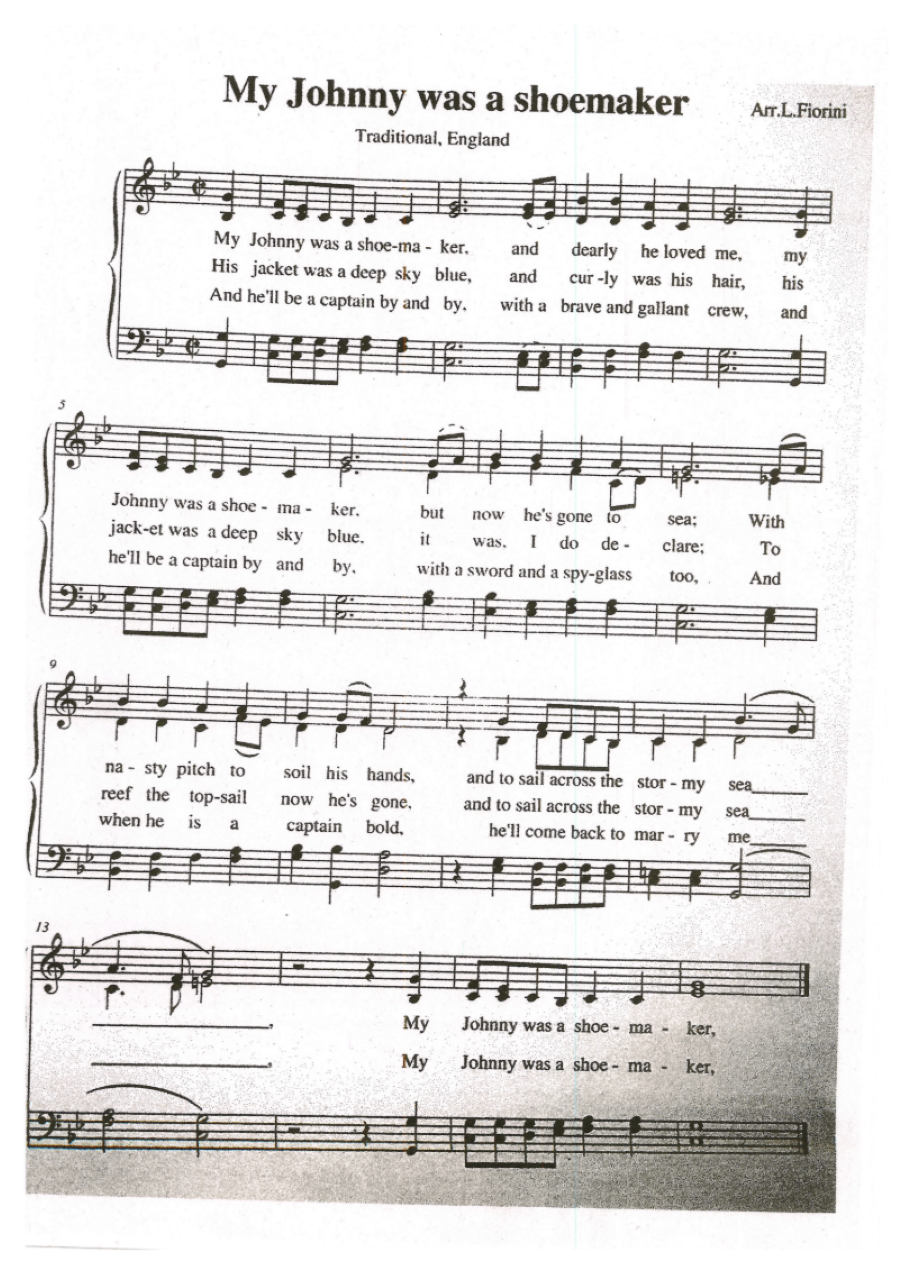

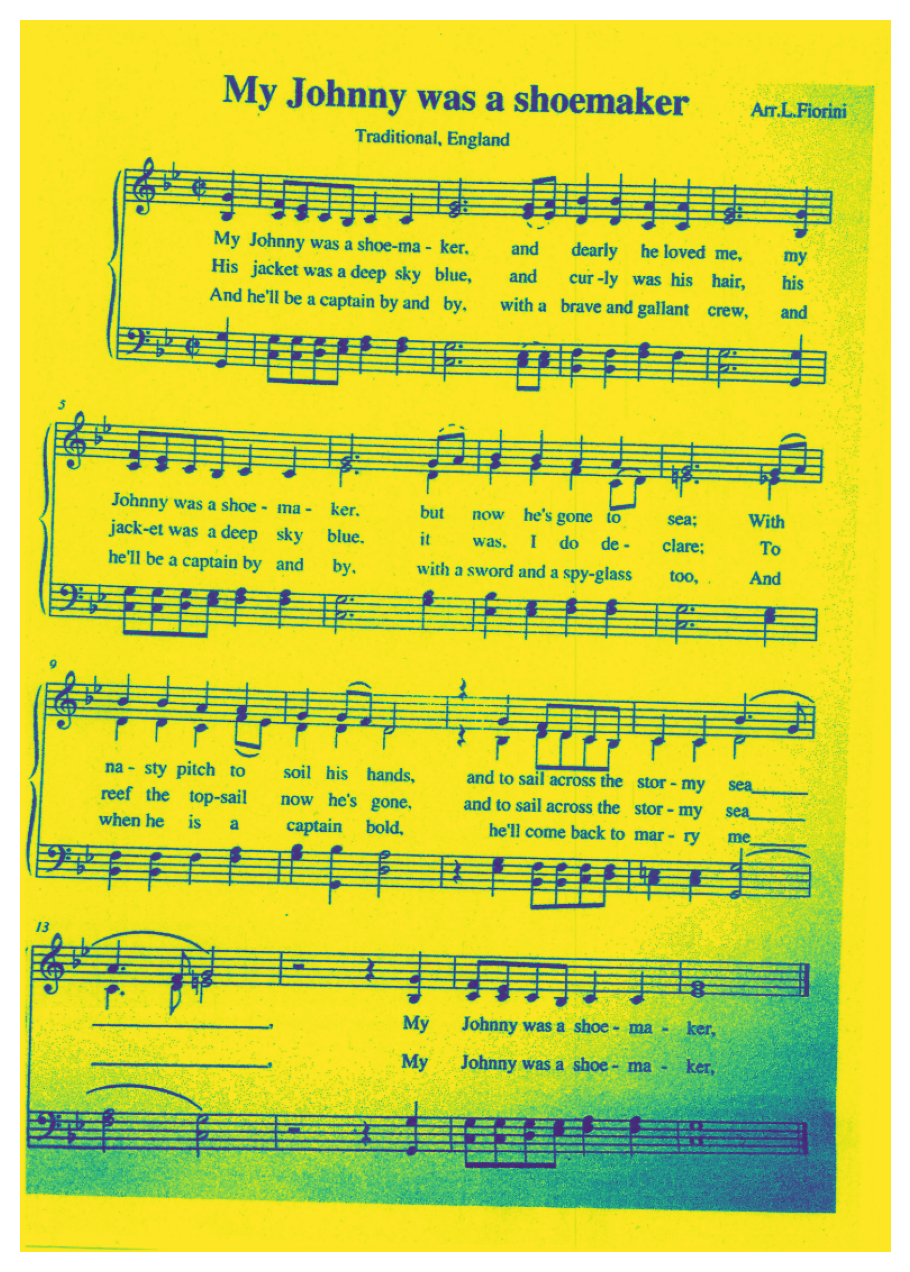

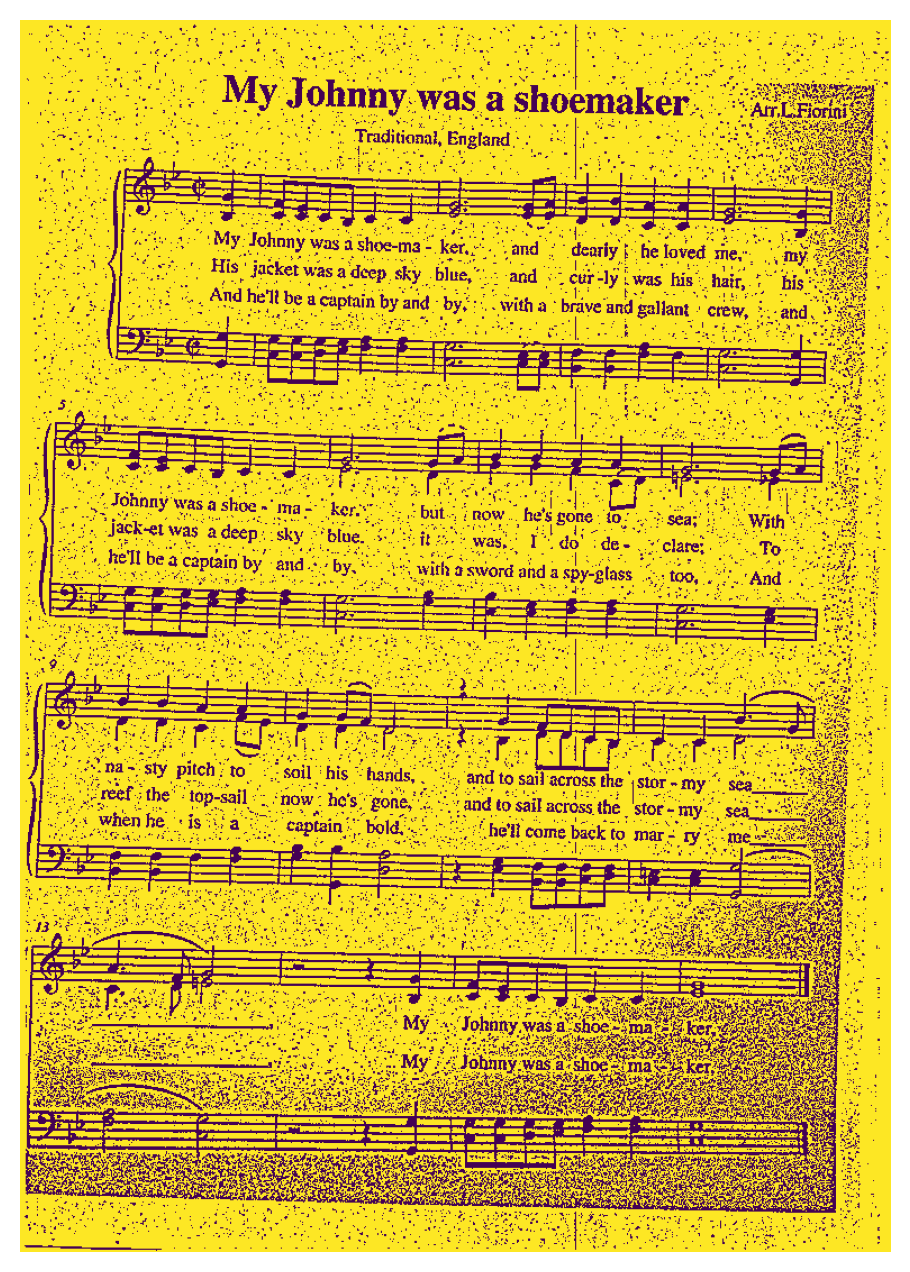

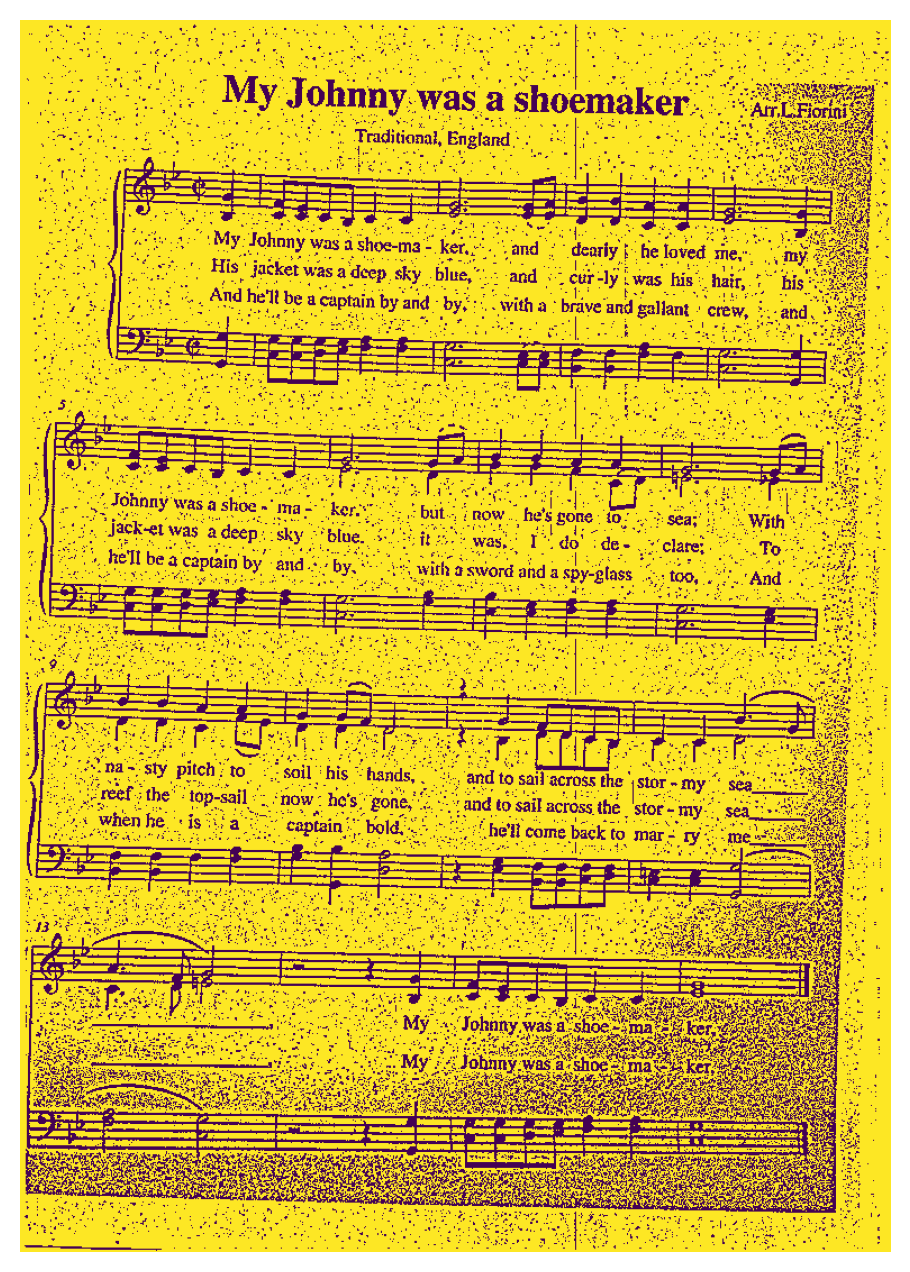

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8)) # Optional: Größe anpassen
plt.imshow(colorful)
plt.axis('off') # Versteckt die Achsen (Pixel-Koordinaten)
plt.show()

plt.figure(figsize=(10, 8)) # Optional: Größe anpassen
plt.imshow(gray)
plt.axis('off') # Versteckt die Achsen (Pixel-Koordinaten)
plt.show()

# plt.figure(figsize=(10, 8)) # Optional: Größe anpassen
# plt.imshow(final_binary)
# plt.axis('off') # Versteckt die Achsen (Pixel-Koordinaten)
# plt.show()

plt.figure(figsize=(10, 8)) # Optional: Größe anpassen
plt.imshow(binary)
plt.axis('off') # Versteckt die Achsen (Pixel-Koordinaten)
plt.show()

plt.figure(figsize=(10, 8)) # Optional: Größe anpassen
plt.imshow(final)
plt.axis('off') # Versteckt die Achsen (Pixel-Koordinaten)
plt.show()

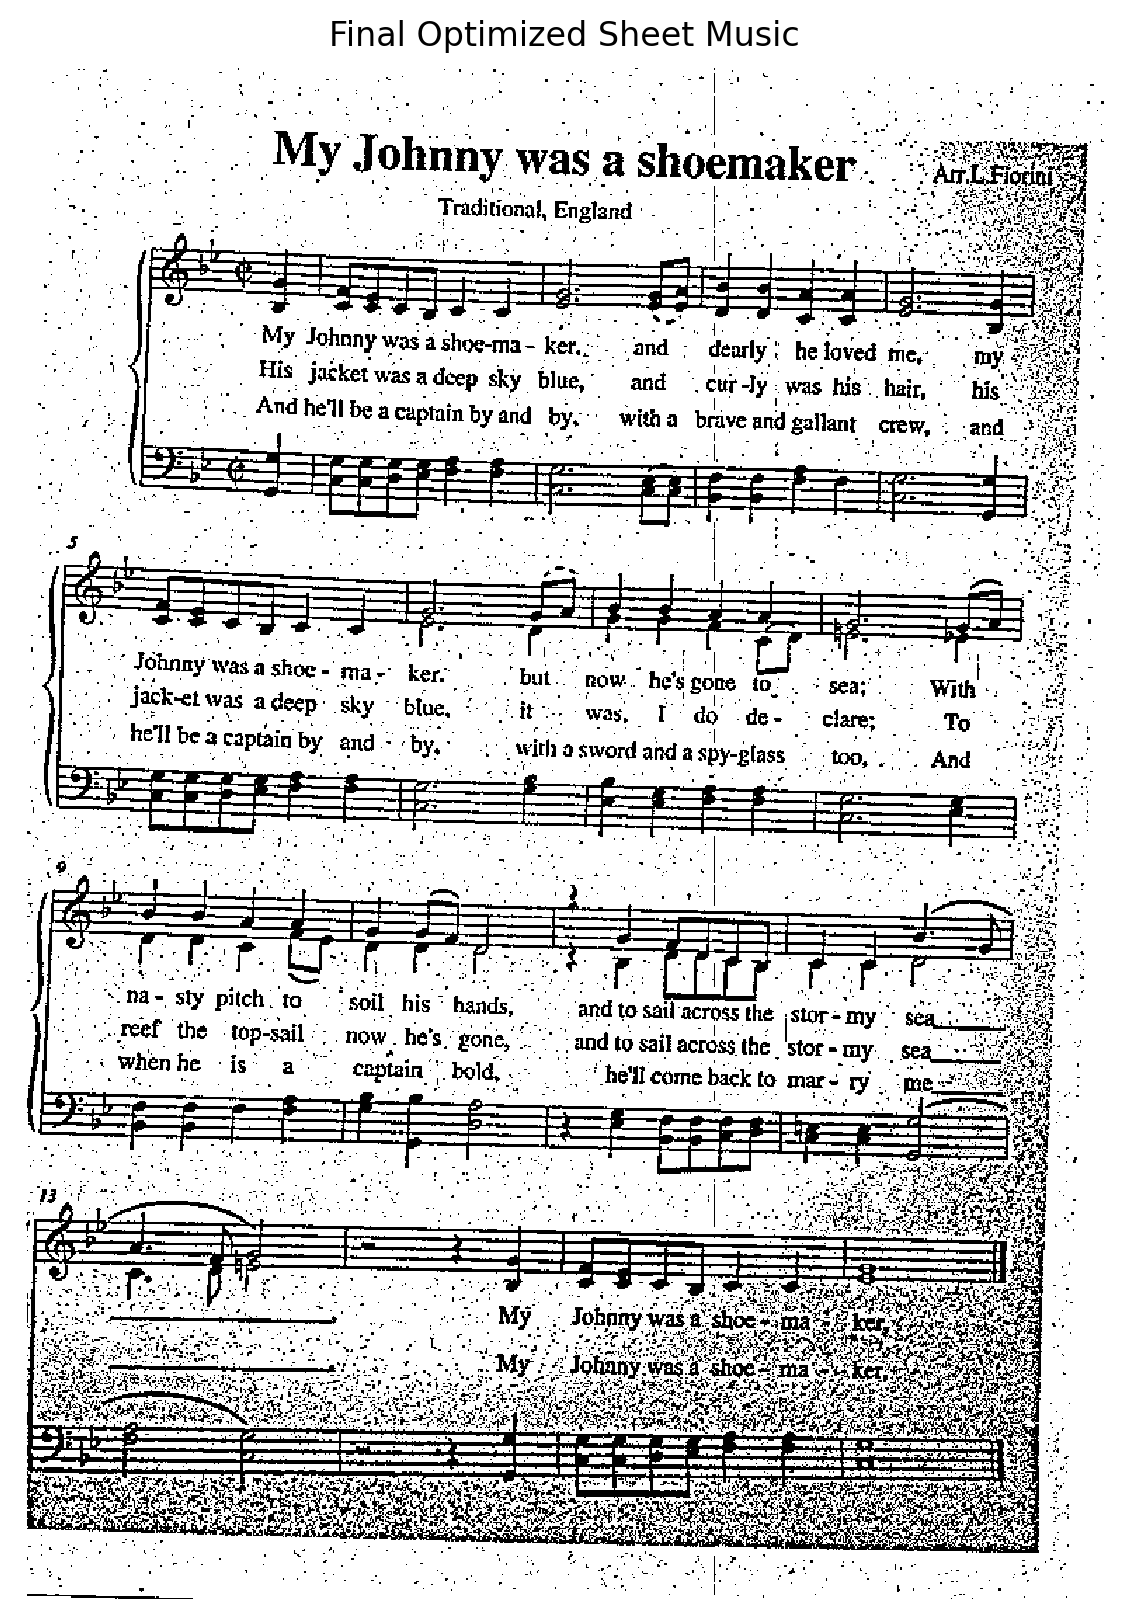

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_sheet_music(img_path):
    # 1. Load & Grayscale
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. SCHATTEN-ELIMINIERUNG (Die "Adobe" Division-Methode)
    # Wir isolieren den Hintergrund (Licht-Map)
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    bg = cv2.morphologyEx(gray, cv2.MORPH_DILATE, struct_elem)
    bg = cv2.GaussianBlur(bg, (51, 51), 0)
    # Division hebt die Schatten auf und bringt alles auf ein Helligkeitsniveau
    normalized = cv2.divide(gray, bg, scale=255)

    # 3. KONTRAST-BOOST (CLAHE)
    # Contrast Limited Adaptive Histogram Equalization
    # Das macht die Notenlinien tiefschwarz, ohne das Rauschen zu verstärken
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(normalized)

    # 4. ADAPTIVE BINARISIERUNG
    # Da das Bild nun flach und kontrastreich ist, liefert Adaptive Threshold
    # hier extrem saubere Kanten ohne die typischen Schatten-Artefakte.
    binary = cv2.adaptiveThreshold(
        enhanced, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 15, 8
    )

    # 5. CLEANUP (Morphologie)
    # Entfernt kleine "Pfeffer-Punkte" (Rauschen), die durch den Scan entstehen
    kernel = np.ones((2,2), np.uint8)
    final = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return binary

# Anwendung
result = process_sheet_music('johnny.png')

# Das Finale: Korrekte Anzeige
plt.figure(figsize=(15, 10))
plt.imshow(result, cmap='gray', interpolation='none')
plt.title('Final Optimized Sheet Music')
plt.axis('off')
plt.show()